In [2]:
import pandas as pd
import numpy as np

C:\Users\pierr\AppData\Local\Temp\ipykernel_16148\2162656668.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
Emp = pd.read_csv("employee_survey_data.csv")
Mgr = pd.read_csv("manager_survey_data.csv")
Gen = pd.read_csv("general_data.csv")
Tin = pd.read_csv("in_out_time/in_time.csv")
Tou = pd.read_csv("in_out_time/out_time.csv")

In [4]:
Tin = Tin.rename(columns={"Unnamed: 0": "EmployeeID"})
Tou = Tou.rename(columns={"Unnamed: 0": "EmployeeID"})

# ---------- TIN ----------
tin_dt = Tin.drop(columns=["EmployeeID"]).apply(pd.to_datetime, errors="coerce")
tin_sec = tin_dt.apply(lambda c: c.dt.hour * 3600 + c.dt.minute * 60 + c.dt.second)

tin_agg = pd.DataFrame({
    "EmployeeID": Tin["EmployeeID"],
    "Time_in_min":  tin_sec.min(axis=1),
    "Time_in_max":  tin_sec.max(axis=1),
    "Time_in_mean": tin_sec.mean(axis=1),
})

# ---------- TOUT ----------
tout_dt = Tou.drop(columns=["EmployeeID"]).apply(pd.to_datetime, errors="coerce")
tout_sec = tout_dt.apply(lambda c: c.dt.hour * 3600 + c.dt.minute * 60 + c.dt.second)

tout_agg = pd.DataFrame({
    "EmployeeID": Tou["EmployeeID"],
    "Time_out_min":  tout_sec.min(axis=1),
    "Time_out_max":  tout_sec.max(axis=1),
    "Time_out_mean": tout_sec.mean(axis=1),
})

# ---------- FINAL (numeric only) ----------
Time_features = tin_agg.merge(tout_agg, on="EmployeeID", how="inner")

Time_features

,EmployeeID,Time_in_min,Time_in_max,Time_in_mean,Time_out_min,Time_out_max,Time_out_mean
0,1,33187.0,38279.0,36005.120690,58690.0,65646.0,62550.262931
1,2,33159.0,38609.0,35957.063559,59223.0,67793.0,63745.351695
2,3,32903.0,39147.0,36090.219008,57504.0,65271.0,61337.884298
3,4,33123.0,39044.0,35934.587234,57769.0,65416.0,61831.829787
4,5,33482.0,39295.0,35994.575510,60791.0,69721.0,64816.804082
...,...,...,...,...,...,...,...
4405,4406,33334.0,38815.0,36071.242798,62857.0,71994.0,66751.440329
4406,4407,33922.0,38525.0,36015.294606,54084.0,62145.0,57949.929461
4407,4408,33020.0,39182.0,35927.904762,59644.0,68675.0,63671.779221
4408,4409,32657.0,38575.0,36066.767635,66429.0,73867.0,70240.107884


In [5]:
df_view = Time_features.copy()

for c in [
    "Time_in_min","Time_in_max","Time_in_mean",
    "Time_out_min","Time_out_max","Time_out_mean"
]:
    sec = (df_view[c] % 86400).astype(int) 
    df_view[c] = (
        (sec // 3600).astype(str).str.zfill(2) + ":" +
        ((sec % 3600) // 60).astype(str).str.zfill(2) + ":" +
        (sec % 60).astype(str).str.zfill(2)
    )

df_view


,EmployeeID,Time_in_min,Time_in_max,Time_in_mean,Time_out_min,Time_out_max,Time_out_mean
0,1,09:13:07,10:37:59,10:00:05,16:18:10,18:14:06,17:22:30
1,2,09:12:39,10:43:29,09:59:17,16:27:03,18:49:53,17:42:25
2,3,09:08:23,10:52:27,10:01:30,15:58:24,18:07:51,17:02:17
3,4,09:12:03,10:50:44,09:58:54,16:02:49,18:10:16,17:10:31
4,5,09:18:02,10:54:55,09:59:54,16:53:11,19:22:01,18:00:16
...,...,...,...,...,...,...,...
4405,4406,09:15:34,10:46:55,10:01:11,17:27:37,19:59:54,18:32:31
4406,4407,09:25:22,10:42:05,10:00:15,15:01:24,17:15:45,16:05:49
4407,4408,09:10:20,10:53:02,09:58:47,16:34:04,19:04:35,17:41:11
4408,4409,09:04:17,10:42:55,10:01:06,18:27:09,20:31:07,19:30:40


In [6]:
# --- Rename to avoid collisions (safe if columns missing) ---
Emp = Emp.rename(columns={
    "EnvironmentSatisfaction": "Emp_EnvironmentSatisfaction",
    "JobSatisfaction": "Emp_JobSatisfaction",
    "WorkLifeBalance": "Emp_WorkLifeBalance",
})

Mgr = Mgr.rename(columns={
    "JobInvolvement": "Mgr_JobInvolvement",
    "PerformanceRating": "Mgr_PerformanceRating",
})

# --- Ensure numeric manager columns (robust coercion) ---
for c in ["Mgr_JobInvolvement", "Mgr_PerformanceRating"]:
    if c in Mgr.columns:
        Mgr[c] = pd.to_numeric(Mgr[c], errors="coerce")

# --- Merge ---
EmpMgr = Emp.merge(Mgr, on="EmployeeID", how="left")
GenEmpMgr = Gen.merge(EmpMgr, on="EmployeeID", how="left")

# --- Drop constant/useless columns safely ---
GenEmpMgr = GenEmpMgr.drop(columns=["Over18", "EmployeeCount", "StandardHours"], errors="ignore")

GenEmpMgr

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Emp_EnvironmentSatisfaction,Emp_JobSatisfaction,Emp_WorkLifeBalance,Mgr_JobInvolvement,Mgr_PerformanceRating
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,...,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,2,Female,1,...,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,3,Male,4,...,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,4,Male,3,...,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,5,Male,1,...,9.0,2,6,0,4,4.0,1.0,3.0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,4406,Female,1,...,10.0,5,3,0,2,4.0,1.0,3.0,3,3
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,4407,Male,1,...,10.0,2,3,0,2,4.0,4.0,3.0,2,3
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,4408,Male,2,...,5.0,4,4,1,2,1.0,3.0,3.0,3,4
4408,42,No,Travel_Rarely,Sales,18,2,Medical,4409,Male,1,...,10.0,2,9,7,8,4.0,1.0,3.0,2,3


In [7]:
features = GenEmpMgr.merge(Time_features, on="EmployeeID", how="left")

In [8]:
features.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeID', 'Gender', 'JobLevel',
       'JobRole', 'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked',
       'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'Emp_EnvironmentSatisfaction',
       'Emp_JobSatisfaction', 'Emp_WorkLifeBalance', 'Mgr_JobInvolvement',
       'Mgr_PerformanceRating', 'Time_in_min', 'Time_in_max', 'Time_in_mean',
       'Time_out_min', 'Time_out_max', 'Time_out_mean'],
      dtype='object')

In [9]:
features.to_csv("features.csv", index=False)

In [10]:
# Strict encoding: NA after mapping = ERROR
s = features["Attrition"].astype(str).str.strip()

mapped = s.map({"Yes": 1, "No": 0})

# If anything didn't map, stop and show the offending values
if mapped.isna().any():
    bad = s[mapped.isna()].unique()
    raise ValueError(f"Attrition mapping failed. Unexpected values: {bad}")

# Now it's safe to use numpy int64 (no NA possible)
features["Attrition"] = mapped.astype("int64")

In [11]:
features.dtypes

Age                              int64
Attrition                        int64
BusinessTravel                  object
Department                      object
DistanceFromHome                 int64
Education                        int64
EducationField                  object
EmployeeID                       int64
Gender                          object
JobLevel                         int64
JobRole                         object
MaritalStatus                   object
MonthlyIncome                    int64
NumCompaniesWorked             float64
PercentSalaryHike                int64
StockOptionLevel                 int64
TotalWorkingYears              float64
TrainingTimesLastYear            int64
YearsAtCompany                   int64
YearsSinceLastPromotion          int64
YearsWithCurrManager             int64
Emp_EnvironmentSatisfaction    float64
Emp_JobSatisfaction            float64
Emp_WorkLifeBalance            float64
Mgr_JobInvolvement               int64
Mgr_PerformanceRating    

In [12]:
target = "Attrition"

In [13]:
from scipy.stats import mannwhitneyu

num_cols = (
    features
    .select_dtypes(include=["int64", "float64"])
    .columns
    .drop([target, "EmployeeID"])
)

mw_results = []

for col in num_cols:
    g0 = features.loc[features[target] == 0, col]
    g1 = features.loc[features[target] == 1, col]

    if g0.notna().any() and g1.notna().any():
        _, p = mannwhitneyu(g0, g1, alternative="two-sided")
        mw_results.append({
            "feature": col,
            "p_value": p,
            "median_no": g0.median(),
            "median_yes": g1.median()
        })

mw_df = pd.DataFrame(mw_results).sort_values("p_value")
mw_df

,feature,p_value,median_no,median_yes
23,Time_out_mean,7.817653e-37,62340.178723,65455.024390
10,YearsAtCompany,1.209520e-36,6.000000,3.000000
21,Time_out_min,1.806233e-36,58186.000000,61369.000000
22,Time_out_max,4.323970e-36,66487.000000,69601.000000
12,YearsWithCurrManager,2.473097e-31,3.000000,2.000000
0,Age,5.990318e-30,36.000000,32.000000
11,YearsSinceLastPromotion,4.042361e-04,1.000000,1.000000
9,TrainingTimesLastYear,1.033591e-02,3.000000,3.000000
6,PercentSalaryHike,3.732026e-02,14.000000,14.000000
4,MonthlyIncome,1.071546e-01,49300.000000,49080.000000


In [14]:
very_strong = []
strong = []
moderate = []
weak = []
not_significant = []
not_testable = []

for _, row in mw_df.iterrows():
    p = row["p_value"]
    feature = row["feature"]

    match p:
        case _ if pd.isna(p):
            not_testable.append(feature)

        case _ if p < 1e-10:
            very_strong.append(feature)

        case _ if p < 1e-5:
            strong.append(feature)

        case _ if p < 0.01:
            moderate.append(feature)

        case _ if p < 0.05:
            weak.append(feature)

        case _:
            not_significant.append(feature)

print("=== Very strong linkage (p < 1e-10) ===")
print(very_strong, "\n")

print("=== Strong linkage (1e-10 ≤ p < 1e-5) ===")
print(strong, "\n")

print("=== Moderate linkage (1e-5 ≤ p < 0.01) ===")
print(moderate, "\n")

print("=== Weak linkage (0.01 ≤ p < 0.05) ===")
print(weak, "\n")

print("=== Not significant (p ≥ 0.05) ===")
print(not_significant, "\n")

print("=== Not testable (p = NaN) ===")
print(not_testable)


=== Very strong linkage (p < 1e-10) ===
['Time_out_mean', 'YearsAtCompany', 'Time_out_min', 'Time_out_max', 'YearsWithCurrManager', 'Age'] 

=== Strong linkage (1e-10 ≤ p < 1e-5) ===
[] 

=== Moderate linkage (1e-5 ≤ p < 0.01) ===
['YearsSinceLastPromotion'] 

=== Weak linkage (0.01 ≤ p < 0.05) ===
['TrainingTimesLastYear', 'PercentSalaryHike'] 

=== Not significant (p ≥ 0.05) ===
['MonthlyIncome', 'Mgr_PerformanceRating', 'Education', 'Mgr_JobInvolvement', 'StockOptionLevel', 'Time_in_min', 'JobLevel', 'DistanceFromHome', 'Time_in_max', 'Time_in_mean'] 

=== Not testable (p = NaN) ===
['NumCompaniesWorked', 'TotalWorkingYears', 'Emp_EnvironmentSatisfaction', 'Emp_JobSatisfaction', 'Emp_WorkLifeBalance']


In [15]:
from scipy.stats import chi2_contingency

cat_cols = (
    features
    .select_dtypes(include=["object", "category"])
    .columns
)

chi2_results = []

for col in cat_cols:
    table = pd.crosstab(features[col], features[target])

    if table.shape[0] > 1:
        chi2, p, _, _ = chi2_contingency(table)

        n = table.to_numpy().sum()
        k = min(table.shape) - 1
        cramer_v = np.sqrt(chi2 / (n * k)) if k > 0 else 0

        chi2_results.append({
            "feature": col,
            "p_value": p,
            "cramers_v": cramer_v
        })

chi2_df = pd.DataFrame(chi2_results).sort_values("p_value")
chi2_df


,feature,p_value,cramers_v
5,MaritalStatus,8.453859e-31,0.177211
0,BusinessTravel,1.764277e-16,0.128260
2,EducationField,8.288917e-09,0.102348
1,Department,4.820888e-07,0.081218
4,JobRole,1.485545e-03,0.075467
3,Gender,2.452948e-01,0.017496


In [17]:
strong = []
moderate = []
weak = []
negligible = []
not_testable = []

for _, row in chi2_df.iterrows():
    v = row["cramers_v"]
    feature = row["feature"]

    match v:
        case _ if pd.isna(v):
            not_testable.append(feature)

        case _ if v >= 0.20:
            strong.append(feature)

        case _ if v >= 0.10:
            moderate.append(feature)

        case _ if v >= 0.05:
            weak.append(feature)

        case _:
            negligible.append(feature)

print("=== Strong association (V ≥ 0.20) ===")
print(strong, "\n")

print("=== Moderate association (0.10 ≤ V < 0.20) ===")
print(moderate, "\n")

print("=== Weak association (0.05 ≤ V < 0.10) ===")
print(weak, "\n")

print("=== Negligible association (V < 0.05) ===")
print(negligible, "\n")

print("=== Not testable (V = NaN) ===")
print(not_testable)


=== Strong association (V ≥ 0.20) ===
[] 

=== Moderate association (0.10 ≤ V < 0.20) ===
['MaritalStatus', 'BusinessTravel', 'EducationField'] 

=== Weak association (0.05 ≤ V < 0.10) ===
['Department', 'JobRole'] 

=== Negligible association (V < 0.05) ===
['Gender'] 

=== Not testable (V = NaN) ===
[]


In [ ]:
print("=== Very strong linkage (p < 1e-10) ===")
print(very_strong, "\n")

print("=== Strong linkage (1e-10 ≤ p < 1e-5) ===")
print(strong, "\n")

print("=== Moderate linkage (1e-5 ≤ p < 0.01) ===")
print(moderate, "\n")

print("=== Weak linkage (0.01 ≤ p < 0.05) ===")
print(weak, "\n")

print("=== Not significant (p ≥ 0.05) ===")
print(not_significant, "\n")

print("=== Not testable (p = NaN) ===")
print(not_testable)

print("=== Strong association (V ≥ 0.20) ===")
print(strong, "\n")

print("=== Moderate association (0.10 ≤ V < 0.20) ===")
print(moderate, "\n")

print("=== Weak association (0.05 ≤ V < 0.10) ===")
print(weak, "\n")

print("=== Negligible association (V < 0.05) ===")
print(negligible, "\n")

print("=== Not testable (V = NaN) ===")
print(not_testable)

=== Very strong linkage (p < 1e-10) ===
['Time_out_mean', 'YearsAtCompany', 'Time_out_min', 'Time_out_max', 'YearsWithCurrManager', 'Age'] 

=== Strong linkage (1e-10 ≤ p < 1e-5) ===
[] 

=== Moderate linkage (1e-5 ≤ p < 0.01) ===
['MaritalStatus', 'BusinessTravel', 'EducationField'] 

=== Weak linkage (0.01 ≤ p < 0.05) ===
['Department', 'JobRole'] 

=== Not significant (p ≥ 0.05) ===
['MonthlyIncome', 'Mgr_PerformanceRating', 'Education', 'Mgr_JobInvolvement', 'StockOptionLevel', 'Time_in_min', 'JobLevel', 'DistanceFromHome', 'Time_in_max', 'Time_in_mean'] 

=== Not testable (p = NaN) ===
[]
=== Strong association (V ≥ 0.20) ===
[] 

=== Moderate association (0.10 ≤ V < 0.20) ===
['MaritalStatus', 'BusinessTravel', 'EducationField'] 

=== Weak association (0.05 ≤ V < 0.10) ===
['Department', 'JobRole'] 

=== Negligible association (V < 0.05) ===
['Gender'] 

=== Not testable (V = NaN) ===
[]


In [ ]:
X = features.drop(columns=["Attrition", "EmployeeID", negligible])
y = features["Attrition"]

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score

# ---------------- Split ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# ---------------- Column selection (dtype-driven) ----------------
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns

# ---------------- Preprocessing with imputers ----------------
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

# ---------------- Logistic Regression ----------------
log_reg = LogisticRegression(
    penalty="elasticnet",
    solver="saga",
    l1_ratio=0.5,
    C=1.0,
    class_weight="balanced",
    max_iter=3000,
    random_state=42
)

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", log_reg)
])

# ---------------- Fit ----------------
pipe.fit(X_train, y_train)

# ---------------- Evaluation ----------------
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.94      0.76      0.84       925
           1       0.38      0.76      0.50       178

    accuracy                           0.76      1103
   macro avg       0.66      0.76      0.67      1103
weighted avg       0.85      0.76      0.79      1103

ROC AUC: 0.8203947767992712


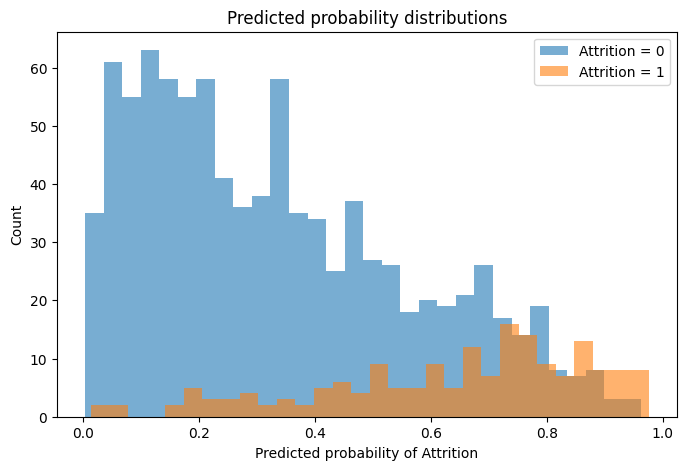

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.hist(y_proba[y_test == 0], bins=30, alpha=0.6, label="Attrition = 0")
plt.hist(y_proba[y_test == 1], bins=30, alpha=0.6, label="Attrition = 1")

plt.xlabel("Predicted probability of Attrition")
plt.ylabel("Count")
plt.legend()
plt.title("Predicted probability distributions")
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, accuracy_score

# ---- choose thresholds to scan ----
thresholds = np.linspace(0.10, 0.90, 81)

# ---- weights (edit anytime) ----
w = {
    "precision_1": 1.0,
    "recall_1":    1.0,
    "f1_1":        1.0,
    "bal_acc":     1.0,
    "accuracy":    0.0,
}

rows = []
for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)

    p1 = precision_score(y_test, y_pred_t, pos_label=1, zero_division=0)
    r1 = recall_score(y_test, y_pred_t, pos_label=1, zero_division=0)
    f1 = f1_score(y_test, y_pred_t, pos_label=1, zero_division=0)
    ba = balanced_accuracy_score(y_test, y_pred_t)
    acc = accuracy_score(y_test, y_pred_t)

    score = (
        w["precision_1"] * p1 +
        w["recall_1"]    * r1 +
        w["f1_1"]        * f1 +
        w["bal_acc"]     * ba +
        w["accuracy"]    * acc
    )

    rows.append({
        "threshold": t,
        "precision_1": p1,
        "recall_1": r1,
        "f1_1": f1,
        "balanced_accuracy": ba,
        "accuracy": acc,
        "score": score
    })

df_thr = pd.DataFrame(rows).sort_values("score", ascending=False).reset_index(drop=True)

best_threshold = df_thr.loc[0, "threshold"]
best_threshold, df_thr


(0.49,
     threshold  precision_1  recall_1      f1_1  balanced_accuracy  accuracy  \
 0        0.49     0.374317  0.769663  0.503676           0.761048  0.755213   
 1        0.50     0.378151  0.758427  0.504673           0.759213  0.759746   
 2        0.41     0.325328  0.837079  0.468553           0.751512  0.693563   
 3        0.43     0.335648  0.814607  0.475410           0.752168  0.709882   
 4        0.48     0.361478  0.769663  0.491921           0.754021  0.743427   
 ..        ...          ...       ...       ...                ...       ...   
 76       0.87     0.727273  0.179775  0.288288           0.583401  0.856754   
 77       0.85     0.642857  0.202247  0.307692           0.590313  0.853128   
 78       0.89     0.777778  0.117978  0.204878           0.555746  0.852221   
 79       0.88     0.666667  0.134831  0.224299           0.560929  0.849501   
 80       0.90     0.739130  0.095506  0.169154           0.544510  0.848595   
 
        score  
 0   2.408704  

In [32]:
threshold = 0.49

y_proba = pipe.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= threshold).astype(int)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.75      0.84       925
           1       0.37      0.77      0.50       178

    accuracy                           0.76      1103
   macro avg       0.66      0.76      0.67      1103
weighted avg       0.85      0.76      0.78      1103

